Notebook to:
 - read an AA0.5 HDF5 data file and a station YAML file,
 - convert to SDP datamodels,
 - run calibration, including EEP-based sky model estimation, and
 - plot the results, including closure quantities.

It requires local copies of the HDF5, YAML and EEP files.
EEP files should be converted to .npy format as described in:<br>
https://developer.skatelescope.org/projects/ska-low-mccs-calibration/en/latest/sky-models.html.

In [1]:
###
### Set PATHs and file names here
###

import logging
import os
import sys
import warnings

import h5py
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants
from astropy.time import Time

from ska_low_mccs_calibration.calibration import calibrate_mccs_visibility
from ska_low_mccs_calibration.qa import (
    generate_gaintable_plots,
    generate_gaintable_scatter_plots,
    generate_visibility_plots,
    generate_visibility_comparison_plots,
    generate_closure_comparison_plots,
)
from ska_low_mccs_calibration.utils import (
    read_yaml_config,
    sdp_visibility_datamodel,
)

log = logging.getLogger()
log.setLevel(logging.INFO)
log.addHandler(logging.StreamHandler(sys.stdout))

warnings.filterwarnings("ignore")

from time import perf_counter
ttotal = perf_counter()

<frozen abc>:106: FutureWarning: xarray subclass Visibility should explicitly define __slots__


In [2]:
date_time = "20240917_16659"    # Observation date_time and coarse channels
channel_id = 160                # Observation coarse channel number (obs central freq / 781.25kHz)
eep_file_path = "perturbed64"
eep_file_base = "HARP_SKALA41_randvogel_1m_256_elem_50ohm_"
eep_suffix = ".npz"
station_configuration_file = "s8-6.yaml"

corr_matrix_file_PATH = '.'
corr_matrix_file = f"correlation_burst_{channel_id}_{date_time}_0.hdf5"

# Precision to use when building models (and when converting EEP images to npy)
model_dtype = np.complex64

# HDF5 Data File

In [3]:
datafile = h5py.File(f"{corr_matrix_file_PATH}/{corr_matrix_file}", 'r')

correlation_info = datafile['observation_info']

# Get the metadata associated with the correlation matrices

correlation_metadata = dict(datafile['root'].attrs)

ntimes = correlation_metadata['n_blocks']
int_time = correlation_metadata['tsamp']
nant = correlation_metadata['n_antennas']
nbaselines = (correlation_metadata['n_baselines'])
n_pol = correlation_metadata['n_pols']
n_stokes = correlation_metadata['n_stokes']

assert nbaselines == nant * (nant + 1) // 2, "expecting all auto and cross correlations"
assert n_stokes == 4, "data should contain 4 polarisation products"
assert correlation_metadata['n_chans'] == 1, "data should have a single frequency channel"
assert correlation_metadata['channel_id'] == channel_id, f"assuming frequency channel {channel_id}"

# chop off rounding errors
int_time = round(int_time, 12)

# Get the data associated with the correlation matrices

correlation_data = datafile['correlation_matrix']['data']

# Drop the frequency axis (2nd dim)
assert correlation_data.ndim == 4
assert correlation_data.shape[1] == 1
correlation_data = correlation_data[:, 0, ...]

print("Shape of the correlation data: ", correlation_data.shape, \
      " time_sequence, baseline_number, pol_product")

assert correlation_data.ndim == 3
assert correlation_data.shape[0] == ntimes
assert correlation_data.shape[1] == nbaselines
assert correlation_data.shape[2] == n_stokes

### Get the timestamps associated with the correlation matrices

correlation_times = datafile['sample_timestamps']
correlation_times_array = correlation_times['data'][:, 0]

if ntimes > 1: 
    # drop the first time step?
    correlation_times_array = correlation_times_array[1:]
    correlation_data = correlation_data[1:, :, :]
    ntimes = len(correlation_times_array)

print("Final shape of the correlation data: ", correlation_data.shape, \
      " time_sequence, baseline_number, pol_product")

Shape of the correlation data:  (1, 32896, 4)  time_sequence, baseline_number, pol_product
Final shape of the correlation data:  (1, 32896, 4)  time_sequence, baseline_number, pol_product


# YAML Configuration File

In [4]:
### get the antenna locations from aavs3.yaml, which is as-built

mro_site, antenna_masks, baselines, enu, pol, rotation = read_yaml_config(station_configuration_file)

assert len(antenna_masks) == nant
assert len(baselines[0]) == nbaselines

# Convert antenna positions to numpy array for ease of use and transpose
enu = np.array(enu, dtype=model_dtype(0).real.dtype).T

# Convert yaml antenna masks to visibility masks
masked_antennas = np.where(antenna_masks==True)[0]
print("Masked antennas (zero-based indexing):", masked_antennas)

bl_flags = np.logical_or(
    np.isin(baselines[0], masked_antennas), np.isin(baselines[1], masked_antennas)
)

# May as well flag autos as well
bl_flags = np.logical_or(bl_flags, baselines[0] == baselines[1])

# stack to have the same shape as vis with common flags for XX,XY,YX,YY pol products
vis_flags = np.tile(bl_flags, (4, 1)).T

read_yaml_station: extracting station s8-6
read_yaml_config: station rotation 193.600000 deg
Masked antennas (zero-based indexing): []


# Package data in Visibility data model
 - https://developer.skao.int/projects/ska-sdp-datamodels/en/latest/

In [5]:
###  Package MCCS data in a ska-sdp-datamodels Visibility xarray

# Observing frequency
channel_bw_MHz = 400.0 / 512.0
frequency_MHz = float(channel_id) * channel_bw_MHz

Time_array = (Time(correlation_times_array, format='unix', location=mro_site))
Time_array.format = 'fits'

itime = 0
time = Time_array[itime]
vis = correlation_data[itime]
print(f"Selecting {int_time} seconds of data at {time}")

v_measurement = sdp_visibility_datamodel(
    vis=vis,
    flags=vis_flags,
    uvw=enu[baselines[0]] - enu[baselines[1]],
    ant1=baselines[0],
    ant2=baselines[1],
    location=mro_site,
    antpos_enu=enu,
    time=time,
    int_time=int_time,
    frequency_mhz=frequency_MHz,
)

Selecting 1.98180864 seconds of data at 2024-09-17T04:40:51.820


# Run calibration
 - Includes the generation of models visibilities from PyGDSM + solar sky models and EEP images.
 - Uses https://developer.skao.int/projects/ska-sdp-func-python/en/latest/ calibration routines.

In [6]:
# Show some extra output
log.setLevel(logging.INFO)

# adjust_solar_model: whether or not to refit after estimating the relative galactic and solar contribution
# jones_solve: whether or not to refit with a polarised solver

gain_table, model_vis, calibrated_vis, masked_antennas, info = calibrate_mccs_visibility(
    v_measurement,
    masked_antennas=masked_antennas,
    dtype=model_dtype,
    #
    # Solar model:
    # skymodel="Sun",
    # min_uv=5,
    # jones_solve=False,
    #
    # GSM:
    nside=16,
    adjust_solar_model=True,
    jones_solve=False,
    #
    eep_path=eep_file_path,
    eep_filebase=eep_file_base,
    eep_suffix=eep_suffix,
    eep_rotation_deg=rotation,
    #
    #ignore_eeps=True,
)

print(f"\nTotal run time: {perf_counter() - ttotal:.2f} seconds")

# Print some of the returned QA metrics
print()
print("correlation coeffs [XX,XY,YX,YY]:", [float(f"{x:.3f}") for x in info.corrcoeff])
print("residual vis std. dev [XX,XY,YX,YY]:", [float(f"{x:4.1f}") for x in info.residual_std], "K")
print("residual vis maximum [XX,XY,YX,YY]:", [float(f"{x:4.1f}") for x in info.residual_max], "K")
print(f"number of ant flags initial: {info.n_masked_initial}, final: {info.n_masked_final}")
print(f"xy-phase update: {info.xy_phase:.2f} deg")
print(f"solar adjustment factor: {info.sun_adjustment_factor:.3f}")
print(f"solar elevation: {info.sun_elevation:.2f} deg")
print(f"galactic centre elevation: {info.galactic_centre_elevation:.2f} deg")
print(f"LST = {info.lst:.2f} hrs")

Using a GSM with Galactic and Solar components
predict_vis: Generating phase shifts for DFT from sky to vis
predict_vis: Resampling beam models at LSM pixel centres
predict_vis: Evaluate DFT from sky to vis
predict_vis: Generating phase shifts for DFT from sky to vis
predict_vis: Resampling beam models at LSM pixel centres
predict_vis: Evaluate DFT from sky to vis
solve_gaintable: Starting calibration
solve_gaintable: Using solver gain_substitution
solve_gaintable: Finished calibration
Additional Antennas rejected based on low gains: [16 22 40 136 166 176]
adjust_gsm: Resetting sky model with sun * 1.43
solve_gaintable: Starting calibration
solve_gaintable: Using solver gain_substitution
solve_gaintable: Finished calibration
Estimated XY-phase: 177.44 deg

Total run time: 6.20 seconds

correlation coeffs [XX,XY,YX,YY]: [0.888, 0.568, 0.574, 0.892]
residual vis std. dev [XX,XY,YX,YY]: [9.2, 10.3, 10.2, 10.9] K
residual vis maximum [XX,XY,YX,YY]: [182.2, 87.2, 87.5, 228.1] K
number of an

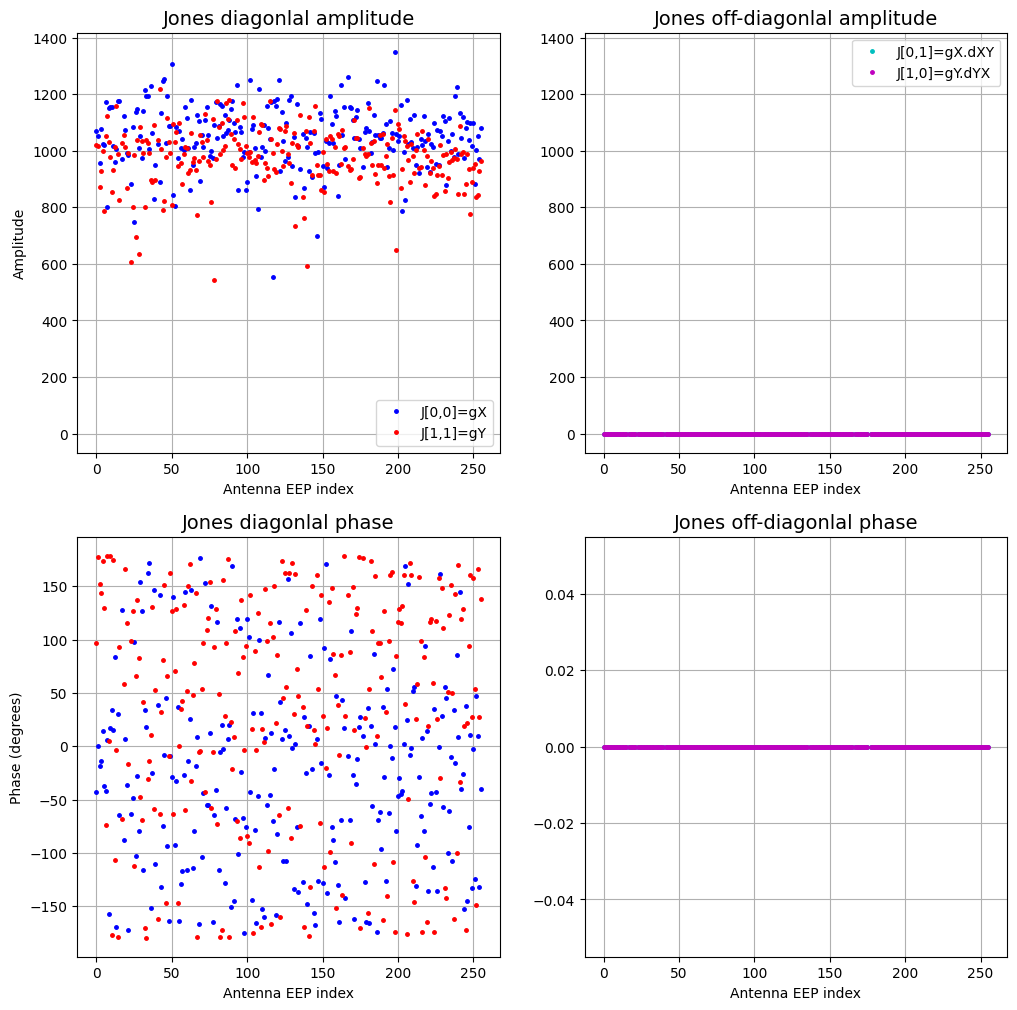

In [7]:
### Plot the gains solutions
fig = generate_gaintable_plots(gain_table, masked_antennas)
fig.savefig("gaintable_plots.png")

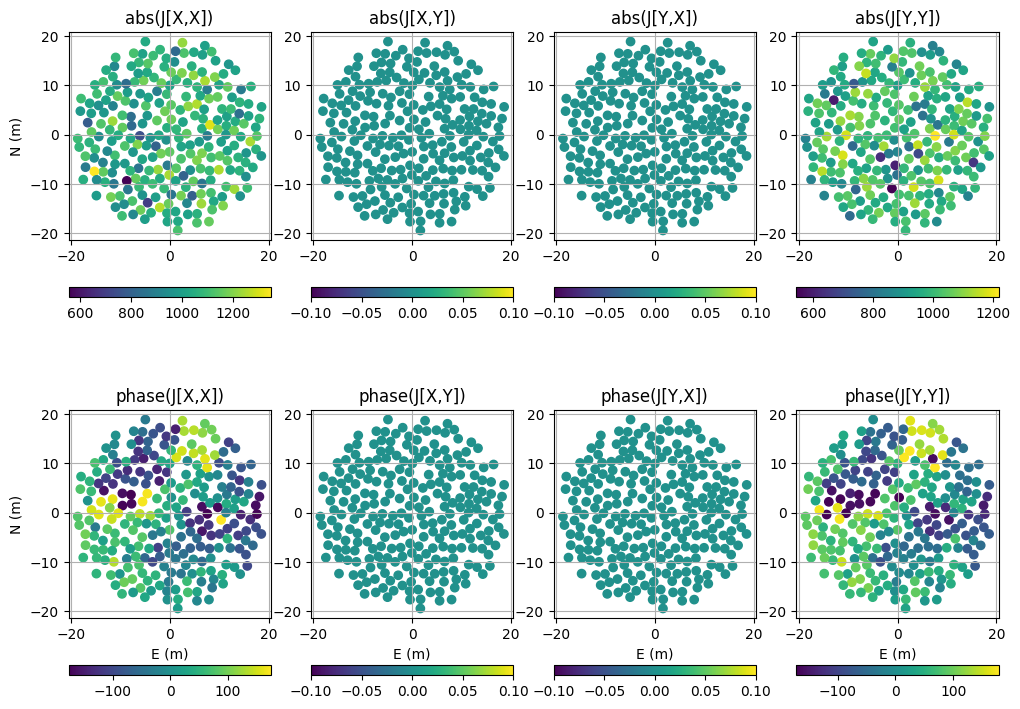

In [8]:
### Plot the gains solutions
fig = generate_gaintable_scatter_plots(gain_table, masked_antennas, enu, refant=0)
fig.savefig("gaintable_scatter_plots.png")

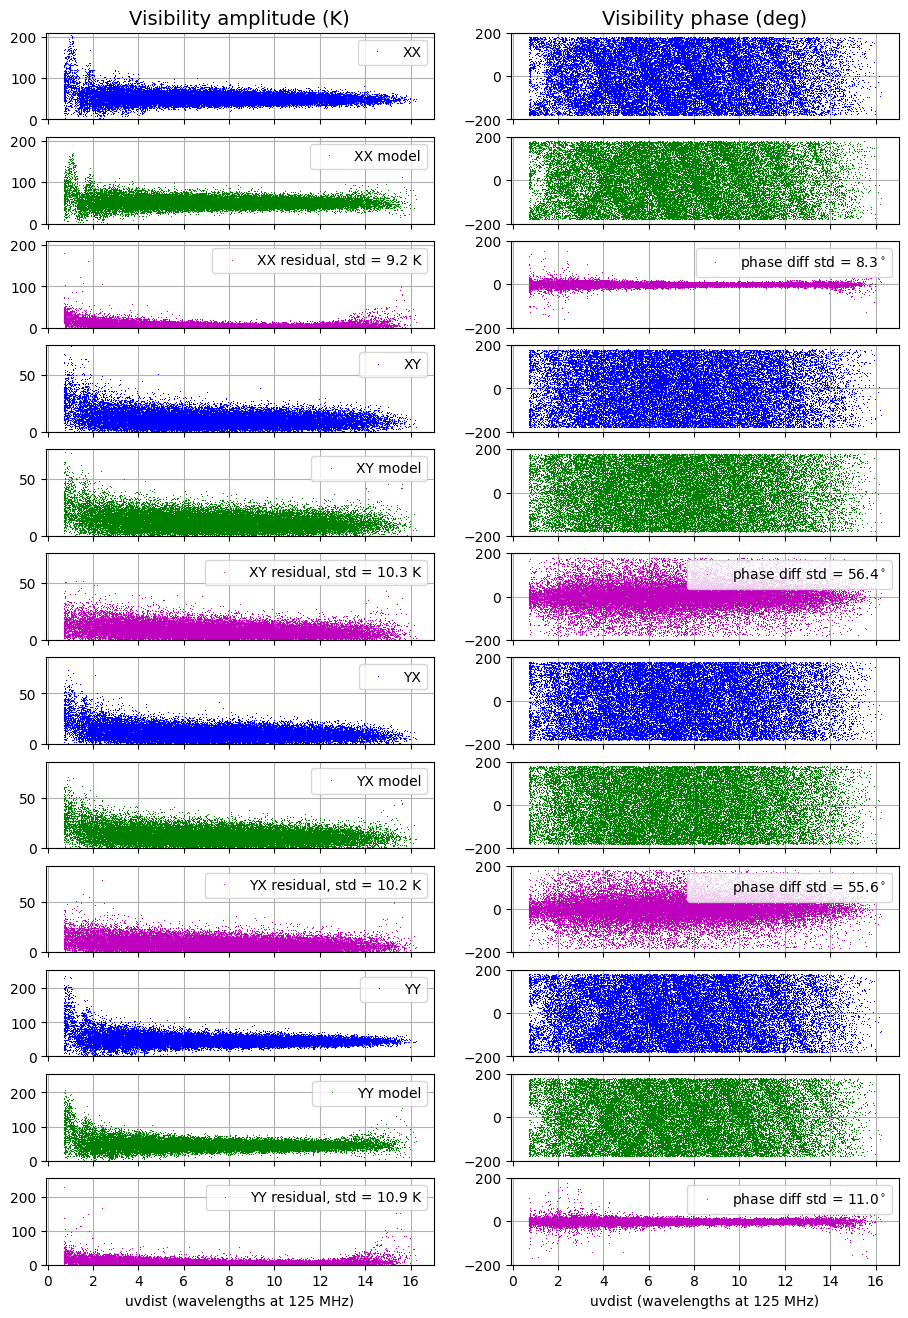

In [9]:
### Plot the calibrated visibilities
fig = generate_visibility_plots(calibrated_vis, model_vis, masked_antennas)
fig.savefig("visibility_plots.png")

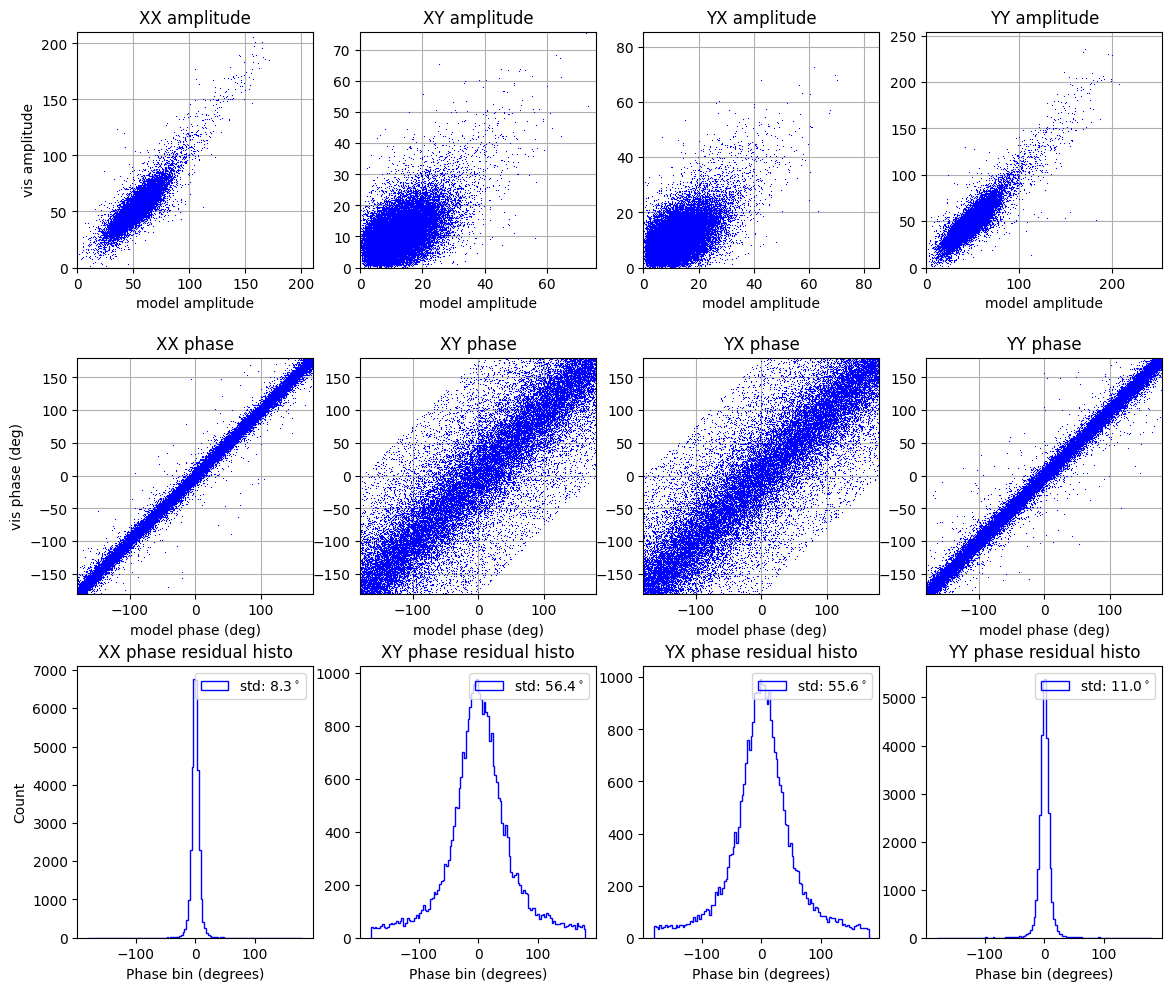

In [10]:
### Visibility comparison plots
fig = generate_visibility_comparison_plots(calibrated_vis, model_vis, masked_antennas)
fig.savefig("visibility_comparison_plots.png")

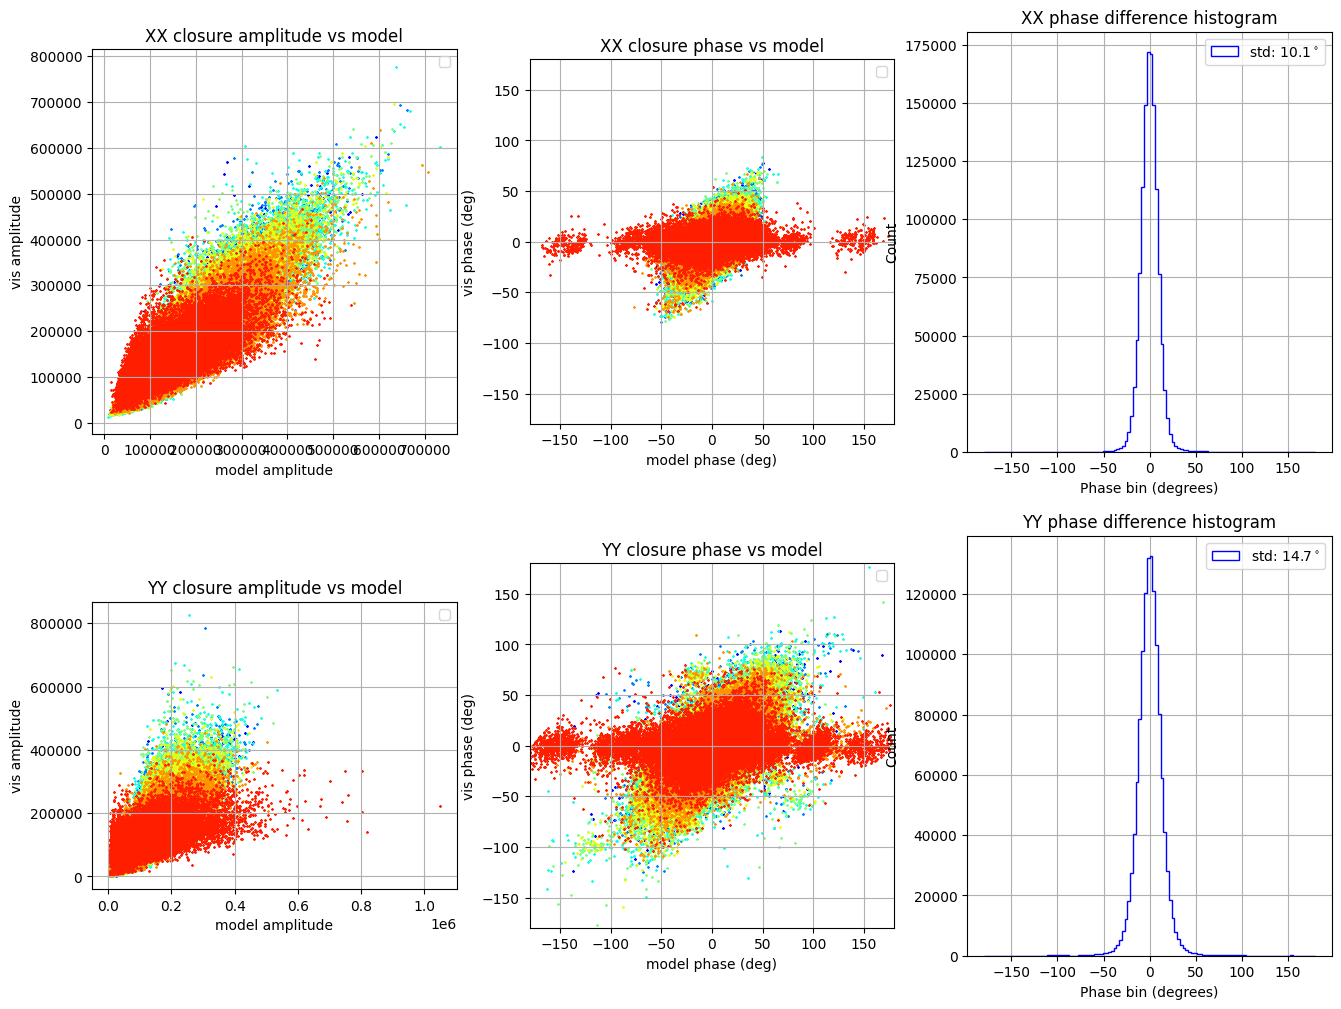

In [11]:
### Closure relation comparison plots
fig = generate_closure_comparison_plots(calibrated_vis, model_vis, masked_antennas, min_uv=10, decimate=1, ctype="uvmax")
fig.savefig("closure_comparison_plots.png")